## Sandbox for Implementing RetinaNet

- start wih pretrined resnet50, maybe from the original paper, or mybe from fastai, doesn't really matter
- then add feature pyramid network and finetune for coco

## General Approach

1. Download CamVid
- Build and train U-Net
- Download COCO
- Build Feature Pyramid Network (FPN) with ResNet backbone
- Build and train RetinaNet with FPN and object detection subnets

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.utils.ipython import *

## CamVid

In [3]:
path = untar_data(URLs.CAMVID_TINY)
path_lbl = path/'labels'
path_img = path/'images'
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

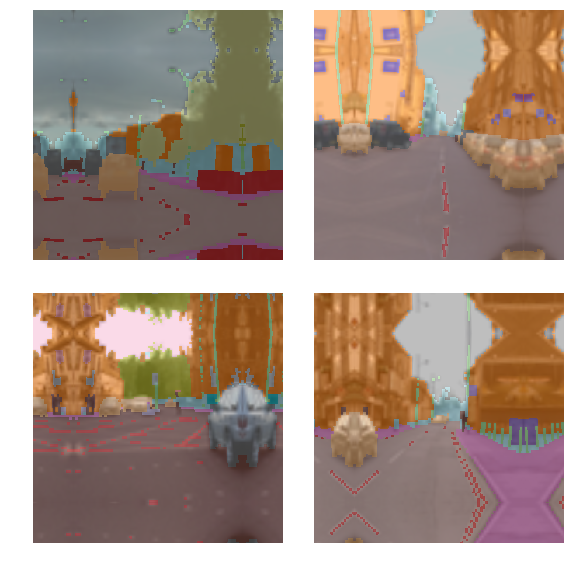

In [4]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
tfms = get_transforms(xtra_tfms=[crop(size=388)])
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(tfms, tfm_y=True, size=572)
        .databunch(bs=6, path=path)
        .normalize(imagenet_stats))
data.show_batch(2)

## U-Net

In [5]:
class Print(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x


class Flatten(nn.Module):
    def forward(self, x): return x.view(x.shape[0], -1)    

In [6]:
class SaveMap():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): self.map = output
    def remove(self): self.hook.remove()
        
        
@dataclass
class DumpMaps(LearnerCallback):
    learn: Learner
    def on_train_end(self, **kwargs):
        self.learn.model.close()

        
@dataclass
class SqueezeUnsqueezeTarget(LearnerCallback):
    learn: Learner
    def on_batch_begin(self, **kwargs):
        crop = (kwargs['last_input'].shape[-1]-388) // 2
        cropped = kwargs['last_target'][:, :, crop:-crop, crop:-crop].squeeze(1)
        return {'last_target': cropped}
    
    
def unet_dice(input, targs):
    targs = targs.unsqueeze(1)
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n, -1)
    targs = targs.contiguous().view(n, -1)
    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [16]:
def conv(ic, oc, k=3, s=1, p=0, actn=True):
    layers = [nn.Conv2d(ic, oc, k, stride=s, padding=p)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers).cuda()


def conv_block(ic, oc, transpose=False, maxpool=True): 
    layers = [conv(ic, oc), Print(), conv(oc, oc)]
    if transpose: layers.append(nn.ConvTranspose2d(oc, oc//2, 2, stride=2))
    if maxpool: layers.append(nn.MaxPool2d(2, stride=2))
    return nn.Sequential(*layers).cuda()


def unet_down(cs): 
    layers = [conv_block(cs[i], cs[i+1]) for i in range(len(cs)-2)]
    layers.append(conv_block(cs[-2], cs[-1], maxpool=False))
    return nn.Sequential(*layers).cuda()


def unet_up(x, maps, classes):
    cs = [m.map.shape[1] for m in maps]
    sz = x.shape[-1]*2
    x = nn.ConvTranspose2d(cs[0], cs[0]//2, 2, stride=2).cuda()(x)
    for i in range(len(cs)-1):
        crop = (maps[i+1].map.shape[-1] - sz) // 2
        cropped = maps[i+1].map[:, :, crop:-crop, crop:-crop]
        x = torch.cat((cropped, x), 1)
        if (len(cs)-1-i) == 1:
            x = conv_block(cs[i], cs[i+1], transpose=False, maxpool=False)(x)
        else:
            x = conv_block(cs[i], cs[i+1], transpose=True, maxpool=False)(x)
        sz = x.shape[-1]
    return F.dropout(conv(cs[-1], classes, k=1, actn=False)(x), p=0.1)


class UNet(nn.Module):
    def __init__(self, backbone, classes):
        super().__init__()
        self.backbone = backbone
        self.classes = classes
        self.maps = [SaveMap(block[-2]) for block in children(backbone)]
        self.maps.reverse()
        
    def forward(self, x): return unet_up(self.backbone(x), self.maps, self.classes)
    def close(self): 
        for mp in self.maps: mp.remove()

In [17]:
cs = [3, 64, 128, 256, 512, 1024]
backbone, classes = unet_down(cs), len(data.classes)
model = UNet(backbone, classes)

In [20]:
learn = Learner(data, 
                model, 
                metrics=unet_dice, 
                opt_func=torch.optim.Adam,
                loss_func=F.cross_entropy,
                callback_fns=[SqueezeUnsqueezeTarget])
learn.init(nn.init.kaiming_normal_)
with gpu_mem_restore_ctx():
    learn.get_preds()

epoch,train_loss,valid_loss,unet_dice,time
0,3.488185,3.481134,-1.174295,00:09


torch.Size([6, 64, 570, 570])
torch.Size([6, 128, 282, 282])
torch.Size([6, 256, 138, 138])
torch.Size([6, 512, 66, 66])
torch.Size([6, 1024, 30, 30])
torch.Size([6, 512, 54, 54])
torch.Size([6, 256, 102, 102])
torch.Size([6, 128, 198, 198])
torch.Size([6, 64, 390, 390])
torch.Size([6, 64, 570, 570])
torch.Size([6, 128, 282, 282])
torch.Size([6, 256, 138, 138])
torch.Size([6, 512, 66, 66])
torch.Size([6, 1024, 30, 30])
torch.Size([6, 512, 54, 54])
torch.Size([6, 256, 102, 102])
torch.Size([6, 128, 198, 198])
torch.Size([6, 64, 390, 390])
torch.Size([6, 64, 570, 570])
torch.Size([6, 128, 282, 282])
torch.Size([6, 256, 138, 138])
torch.Size([6, 512, 66, 66])
torch.Size([6, 1024, 30, 30])
torch.Size([6, 512, 54, 54])
torch.Size([6, 256, 102, 102])
torch.Size([6, 128, 198, 198])
torch.Size([6, 64, 390, 390])
torch.Size([6, 64, 570, 570])
torch.Size([6, 128, 282, 282])
torch.Size([6, 256, 138, 138])
torch.Size([6, 512, 66, 66])
torch.Size([6, 1024, 30, 30])
torch.Size([6, 512, 54, 54])
torc

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


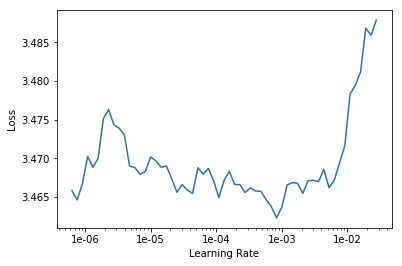

In [13]:
learn.recorder.plot()

epoch,train_loss,valid_loss,unet_dice,time
0,3.485487,3.491637,-1.144913,00:09
1,3.470080,3.516049,-1.169150,00:09
2,3.482996,3.463655,-1.207161,00:09
3,3.478968,3.470018,-1.154611,00:09
4,3.481378,3.478833,-1.151671,00:09
5,3.476997,3.489717,-1.190747,00:09
6,3.480437,3.472306,-1.221812,00:09
7,3.481620,3.460060,-1.142847,00:09
8,3.479536,3.481714,-1.164726,00:09
9,3.474678,3.484942,-1.252674,00:09


Better model found at epoch 0 with unet_dice value: -1.1449131965637207.


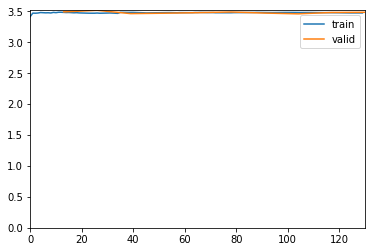

Better model found at epoch 7 with unet_dice value: -1.1428474187850952.


In [14]:
callbacks = [
    ReduceLROnPlateauCallback(learn, patience=5, factor=0.5), 
    SaveModelCallback(learn, monitor='unet_dice', mode='max', name='unet')]
learn.callback_fns.extend([DumpMaps, ShowGraph])
learn.callbacks.extend(callbacks)
learn.fit_one_cycle(10)

In [15]:
model

UNet(
  (backbone): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace)
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace)
      )
      (1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace)
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace)
      )
      (1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplac